In [1]:
%%time
import sys
sys.path.append('../python/')
from tqdm import tqdm
from glob import glob
import pandas as pd
from parametrized_bootstrapping_model import ParametrizedBootstrappingModel, ReturnAlways1Model, ReturnAlways0Model
from result_analysis_utils import load_ground_truth_data, load_evaluations, run_cross_validation, load_cross_validation_results, load_raw_evaluations
from io import StringIO
from trectools import TrecQrel
from sklearn.metrics import mean_squared_error
import numpy as np
import json

if 'df' not in locals() or 'unique_queries' not in locals():
    eval_predictions = glob('../resources/eval/uqv-runs-ecir21*.jsonl')
    
    df = load_evaluations(tqdm(eval_predictions))
    
    unique_queries = set(TrecQrel('../resources/unprocessed/topics-and-qrels/qrels.core17.txt').qrels_data['query'].astype(str).unique())

100%|██████████| 672/672 [00:00<00:00, 993.17it/s]


CPU times: user 2.94 s, sys: 1.36 s, total: 4.31 s
Wall time: 2.47 s


In [30]:
df_aggregated = []

for _,i in df.iterrows():
    tmp = {'run': i['run'], 'type': 'UQV' if 'UQV' in i['run'] else ('_'.join(i['run'].split('.')[:2]).replace("'", ''))}
    
    
    for measure in ['residual-ndcg@10-min', 'residual-ndcg@10-max', 'ndcg@10', 'unjudged@10', 'condensed-ndcg@10']:
        tmp[measure] = sum(json.loads(i[('complete-pool', measure)]).values())/len(unique_queries)
    
    df_aggregated += [tmp]

df_aggregated = pd.DataFrame(df_aggregated)
df_aggregated = df_aggregated.sort_values('ndcg@10', ascending=False).reset_index()
del df_aggregated['index']

df_aggr_tmp = []

for approach_type in df_aggregated['type'].unique():
    tmp = df_aggregated[df_aggregated['type'] == approach_type].copy()
    tmp = tmp.sort_values('ndcg@10', ascending=False).reset_index()
    tmp['Run'] = tmp.index
    df_aggr_tmp += [tmp]

df_aggr_tmp = pd.concat(df_aggr_tmp)

df_for_plot = []
for _, i in df_aggr_tmp.iterrows():
    for measure in ['residual-ndcg@10-min', 'residual-ndcg@10-max', 'ndcg@10', 'unjudged@10', 'condensed-ndcg@10']:
        df_for_plot += [{'Run': i['Run'], 'run': i['run'], 'measure': measure, 'Type': i['type'],'Value': i[measure]}]

df_for_plot = pd.DataFrame(df_for_plot)

In [13]:
df_aggregated

,run,type,residual-ndcg@10-min,residual-ndcg@10-max,ndcg@10,unjudged@10,condensed-ndcg@10
0,KIS.S3'.9,KIS_S3',0.598103,0.636951,0.597911,0.044,0.621194
1,KIS.S3.10,KIS_S3,0.598103,0.636951,0.597911,0.044,0.621194
2,KIS.S3.9,KIS_S3,0.597675,0.630658,0.597454,0.040,0.615113
3,KIS.S3'.8,KIS_S3',0.597675,0.630658,0.597454,0.040,0.615113
4,KIS.S3'.10,KIS_S3',0.595250,0.628433,0.595059,0.046,0.614457
...,...,...,...,...,...,...,...
163,TTS.S1.4,TTS_S1,0.006013,0.979263,0.006013,0.972,0.007909
164,TTS.S1.8,TTS_S1,0.004949,0.977938,0.004949,0.966,0.039248
165,TTS.S1.7,TTS_S1,0.003558,0.972858,0.003558,0.974,0.017032
166,TTS.S1.6,TTS_S1,0.002201,0.974008,0.002201,0.974,0.009741


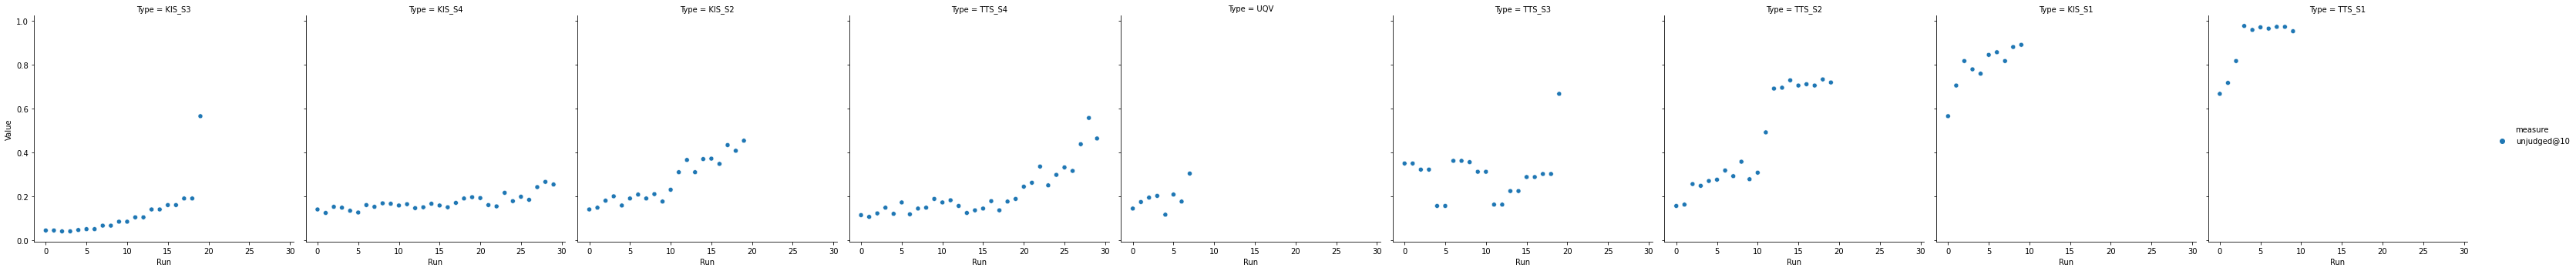

In [31]:
import seaborn as sns

sns.relplot(data=df_for_plot[df_for_plot['measure'] == 'unjudged@10'], x='Run', y='Value', hue='measure', col='Type')

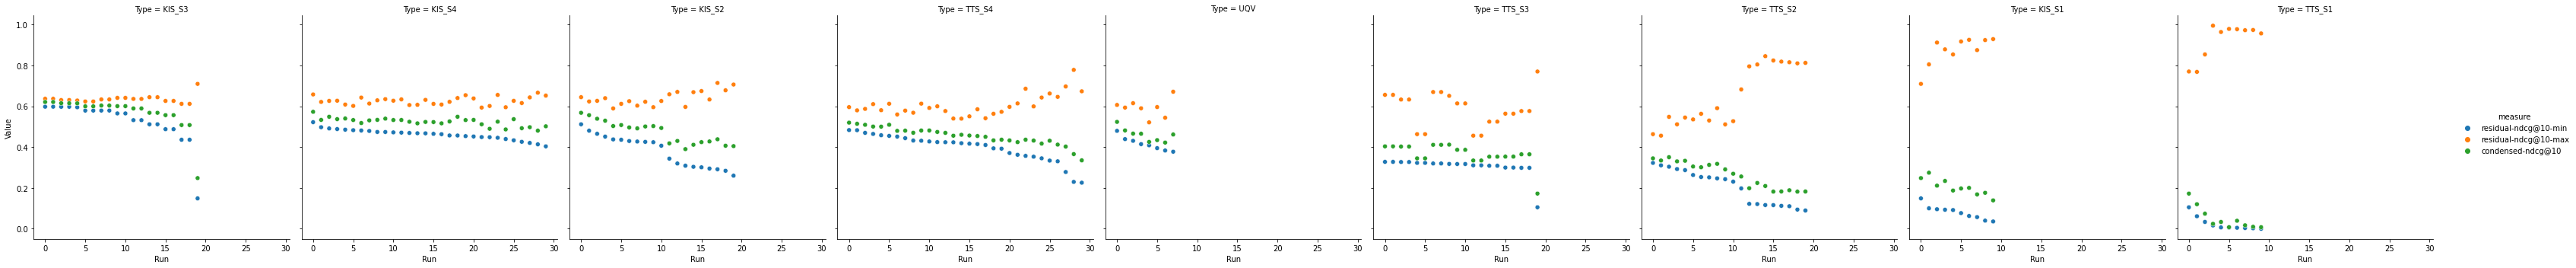

In [32]:
ToDo: Für das paper eine Grafik in der die Klasse, der Kendalls Tau, ... usw drin steht und wie viele ungejugt sind. Dann eine kleine Tabelle in der die gesamtsachen drin sind.

import seaborn as sns

sns.relplot(data=df_for_plot[~df_for_plot['measure'].isin(['unjudged@10', 'ndcg@10'])], x='Run', y='Value', hue='measure', col='Type')

In [ ]:
for aggr_type in df_aggregated['type'].unique():
    

In [42]:
df_aggregated[df_aggregated['type'] == 'KIS_S4'][['ndcg@10', 'condensed-ndcg@10']].corr('kendall').iloc[0]['condensed-ndcg@10']

0.503448275862069

In [36]:
df_aggregated[df_aggregated['type'] == 'KIS_S1'][['ndcg@10', 'condensed-ndcg@10']].corr('kendall')

,ndcg@10,condensed-ndcg@10
ndcg@10,1.000000,0.733333
condensed-ndcg@10,0.733333,1.000000


In [40]:
df_aggregated[df_aggregated['type'] == 'TTS_S1'][['ndcg@10', 'condensed-ndcg@10']].corr('kendall')

,ndcg@10,condensed-ndcg@10
ndcg@10,1.000000,0.733333
condensed-ndcg@10,0.733333,1.000000


In [47]:
df_aggregated[df_aggregated['type'] == 'TTS'][['ndcg@10', 'condensed-ndcg@10']].corr('kendall')

,ndcg@10,condensed-ndcg@10
ndcg@10,1.000000,0.885569
condensed-ndcg@10,0.885569,1.000000


In [48]:
df_aggregated[df_aggregated['type'] == 'UQV'][['ndcg@10', 'condensed-ndcg@10']].corr('kendall')

,ndcg@10,condensed-ndcg@10
ndcg@10,1.000000,0.714286
condensed-ndcg@10,0.714286,1.000000


In [49]:
df_aggregated[['ndcg@10', 'condensed-ndcg@10']].corr('kendall')

,ndcg@10,condensed-ndcg@10
ndcg@10,1.000000,0.877143
condensed-ndcg@10,0.877143,1.000000


In [28]:
df_aggregated['type'].unique()

array(["KIS_S3'", 'KIS_S3', 'KIS_S4', "KIS_S2'", "KIS_S4'", "TTS_S4'",
       'TTS_S4', 'UQV', "KIS_S4''", 'KIS_S2', "TTS_S4''", "TTS_S3'",
       'TTS_S3', "TTS_S2'", 'TTS_S2', 'KIS_S1', 'TTS_S1'], dtype=object)

In [50]:
df_aggregated[['unjudged@10']].describe()

,unjudged@10
count,168.000000
mean,0.314988
std,0.247813
min,0.040000
25%,0.155500
50%,0.201000
75%,0.359000
max,0.978000


In [51]:
df_aggregated

,run,type,residual-ndcg@10-min,residual-ndcg@10-max,ndcg@10,unjudged@10,condensed-ndcg@10
0,KIS.S3'.9,KIS,0.598103,0.636951,0.597911,0.044,0.621194
1,KIS.S3.10,KIS,0.598103,0.636951,0.597911,0.044,0.621194
2,KIS.S3.9,KIS,0.597675,0.630658,0.597454,0.040,0.615113
3,KIS.S3'.8,KIS,0.597675,0.630658,0.597454,0.040,0.615113
4,KIS.S3'.10,KIS,0.595250,0.628433,0.595059,0.046,0.614457
...,...,...,...,...,...,...,...
163,TTS.S1.4,TTS,0.006013,0.979263,0.006013,0.972,0.007909
164,TTS.S1.8,TTS,0.004949,0.977938,0.004949,0.966,0.039248
165,TTS.S1.7,TTS,0.003558,0.972858,0.003558,0.974,0.017032
166,TTS.S1.6,TTS,0.002201,0.974008,0.002201,0.974,0.009741
